<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/setup_tutorials/tutorial_yolo_nas_and_ocsort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO-NAS + OC-SORT**

This notebook contains a tutorial that shows how to incorporate YOLO-NAS with OC-SORT to perform real time visual tracking on a data stream. In this case, we will use a YouTube video to simulate a data stream of image frames.

## **YOLO-NAS**
[YOLO-NAS](https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md) is a powerful object detector with an optimal neural network architecture that has been selected using Neural Architecture Search (NAS), hence the name NAS. 

At the time of release, it outperforms all of the other single shot object detectos in terms of speed and accuracy. It also excels in an area that most single shot detector struggle with, small objects. Two-stage detectors typically perform better than single stage detectors on small objects, at the cost of increased detection time [source](https://arxiv.org/pdf/1907.09408.pdf). YOLO-NAS, howver seems to provide a good tradeoff between detection speed and accuracy on small objects that previous versions of YOLO have not been able to deliver.

## **OC-SORT**
[OC-SORT](https://arxiv.org/abs/2203.14360) is a robust visual obejct tracking algorithm that improves upon the already popular [SORT](https://arxiv.org/abs/1602.00763) algorithm.

SORT tends to loose track on obejcts when they are lost for extended periods of time or when non-linear motion occurs. Algorithms such as Deep SORT have effectoively improved SORT in these scenarios with a Deep Association metric that is computed with a [Siamese Neural Network](https://arxiv.org/pdf/1707.02131.pdf) over the image patches. Eventhough this is effective it comes with the cost of increased detection time due to the deep association and the Siamese network needs to be trained on in-domain data for this approach to be effective. OC-SORT on the otherhand is able to effectively increase tracking performance in a model free fashion with minimal impact to inference speed.

OC-SORT introduces
- Observation Centric Re-Update (ORU)
    - Reduces accumulated Kalman Filter error/uncertainty when a lost track is re-associated
- Observation Centric Momentum (OCM)
    - Uses previous observations to compute a low noise expected motion direction and incorporates it into the track association cost
- Observation Centric Recovery (OCR)
    - Uses the last known observation as a secondary association to help prevent lost tracks

For more details and a break down of each technique that OC-SORT introduces, please see this [article](https://medium.com/@itberrios6/introduction-to-ocsort-c1ea1c6adfa2).

#### Install Libraries

In [3]:
# sketchy fix for "https://stackoverflow.com/questions/73711994/importerror-cannot-import-name-is-directory-from-pil-util-usr-local-lib"
!pip install fastcore -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [315]:
!pip install pytorch-quantization --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install super-gradients
!pip install filterpy
!pip install pytube
!pip install moviepy
!pip install ffmpeg

# bug fix for imageio-ffmpeg
!pip install imageio==2.4.1

### Get OCSORT code

In [98]:
!mkdir ocsort
%cd ocsort
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/ocsort.py 
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/kalmanfilter.py 
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/association.py 

%cd ..

/content/ocsort
--2023-05-07 23:31:40--  https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/ocsort.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18109 (18K) [text/plain]
Saving to: ‘ocsort.py’

ocsort.py           100%[===================>]  17.68K  --.-KB/s    in 0.001s  

2023-05-07 23:31:40 (23.1 MB/s) - ‘ocsort.py’ saved [18109/18109]



In [5]:
import os
import time
import numpy as np
import cv2
import filterpy
import super_gradients as sg
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

[2023-05-07 23:00:46] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-05-07 23:00:51] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Download video from YouTube

In [7]:
from pytube import YouTube

# current bug in PYTube prevents this code from working

url = r"https://www.youtube.com/watch?v=JteKbauGolo"
yt = YouTube(url)
print("Video Title: ", yt.title)

# download video
video_path = yt.streams \
  .filter(progressive=True, file_extension='mp4') \
  .order_by('resolution') \
  .desc() \
  .first() \
  .download() 

Video Title:  Chastain BANZAI last lap move!!


## Instantiate YOLO-NAS model

In [358]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get("yolo_nas_s", pretrained_weights="coco").cuda()

In [ ]:
models.get()

### Quantize model for better speed

In [352]:
from super_gradients.training.utils.quantization.selective_quantization_utils import SelectiveQuantizer


cls_model = models.get(model_name="resnet50", pretrained_weights="imagenet")

q_util = SelectiveQuantizer(
    default_quant_modules_calibrator_weights="max",
    default_quant_modules_calibrator_inputs="histogram",
    default_per_channel_quant_weights=True,
    default_learn_amax=False,
    verbose=True,
)
q_util.quantize_module(cls_model)

AssertionError: ignored

In [353]:
q_util.quantize_module(model)

AssertionError: ignored

In [317]:
q_util

## Perform inference on Simulated Video Stream

#### First we will use MoviePy to get the frame rate and save the audio for later

In [9]:
from moviepy.editor import VideoFileClip

videoclip = VideoFileClip(video_path)
audioclip = videoclip.audio

video_fps = videoclip.fps
video_fps

29.97002997002997

## Instantiate tracker object

In [220]:
from ocsort import ocsort

tracker = ocsort.OCSort(det_thresh=0.25)

Helper function for bounding box colors

In [221]:
import colorsys    

def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    hue = number*30 % 180
    saturation = number*103 % 256
    value = number*50 % 256

    # expects normalized values
    color = colorsys.hsv_to_rgb(hue/179, saturation/255, value/255)

    return [int(c*255) for c in color]

## Now we can simualate the data stream using opencv

Make sure to reset the tracker each time you run the inference

In [343]:
# get frame info for tracker and video saving 
h, w = (720, 1280)
h2, w2 = h//2, w//2
h2, w2 = 640, 640
img_size = (h2, w2) 
img_info = (h2, w2)

In [344]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_class_names',
 '_default_nms_conf',
 '_default_nms_iou',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_get_pipeline',
 '_image_processor',
 '_initialize_weights',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_registe

In [345]:
# ensure tracker is reset
tracker = ocsort.OCSort(det_thresh=0.25)

cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
fps = 0
tic = time.perf_counter()
elapsed = 0
while(cap.isOpened()):

  # read each video frame
  ret, frame = cap.read()

  if ret == True:

    

    # read image and resize
    frame = cv2.resize(
        cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
        (w2, h2), interpolation=cv2.INTER_LINEAR)

    # perform inference
    predictions = model.predict(images=[frame], iou=None, conf=0.25)

    # # get detections
    # img_preds = list(predictions._images_prediction_lst)[0]

    # dets = np.hstack((img_preds.prediction.bboxes_xyxy, 
    #                   np.c_[img_preds.prediction.confidence]))

    # update tracker
    # tracks = tracker.update(dets, img_info, img_size)

    # # draw tracks on frame
    # for track in tracker.trackers:
      
    #   track_id = track.id
    #   hits = track.hits
    #   color = get_color(track_id*15)
    #   x1,y1,x2,y2 = np.round(track.get_state()).astype(int).squeeze()

    #   cv2.rectangle(frame, (x1,y1),(x2,y2), color, 2)
    #   cv2.putText(frame, 
    #               f"{track_id}-{hits}", 
    #               (x1+10,y1+10), 
    #               cv2.FONT_HERSHEY_SIMPLEX, 
    #               1,
    #               color, 
    #               2,
    #               cv2.LINE_AA)
      
    # update FPS
    elapsed += (time.perf_counter() - tic)
    fps = np.round((i+1)/elapsed)
    print(i, np.round(elapsed,2), np.round(fps,2), 
          np.round(time.perf_counter(),2), np.round(tic,2))
    cv2.putText(frame, 
                f"FPS: {fps}", 
                (10,h2 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                2,
                (255,255,255), 
                4,
                cv2.LINE_AA)

    # append to list
    frames.append(frame)

    # TEMP for debug
    if i == 10:
      break
    else:
      i += 1

  # Break the loop
  else:
    break

# When everything done, release
# the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

0 0.03 30.0 6442.18 6442.15
1 0.08 24.0 6442.2 6442.15
2 0.15 20.0 6442.21 6442.15
3 0.23 17.0 6442.23 6442.15
4 0.33 15.0 6442.25 6442.15
5 0.44 14.0 6442.26 6442.15
6 0.57 12.0 6442.28 6442.15
7 0.72 11.0 6442.3 6442.15
8 0.89 10.0 6442.31 6442.15
9 1.06 9.0 6442.33 6442.15
10 1.26 9.0 6442.34 6442.15


In [346]:
10/1.54

6.4935064935064934

In [347]:
tic, time.perf_counter() 

(6442.148347271, 6443.89801491)

In [348]:
i/elapsed

7.936064165636469

In [349]:
# dir(track)

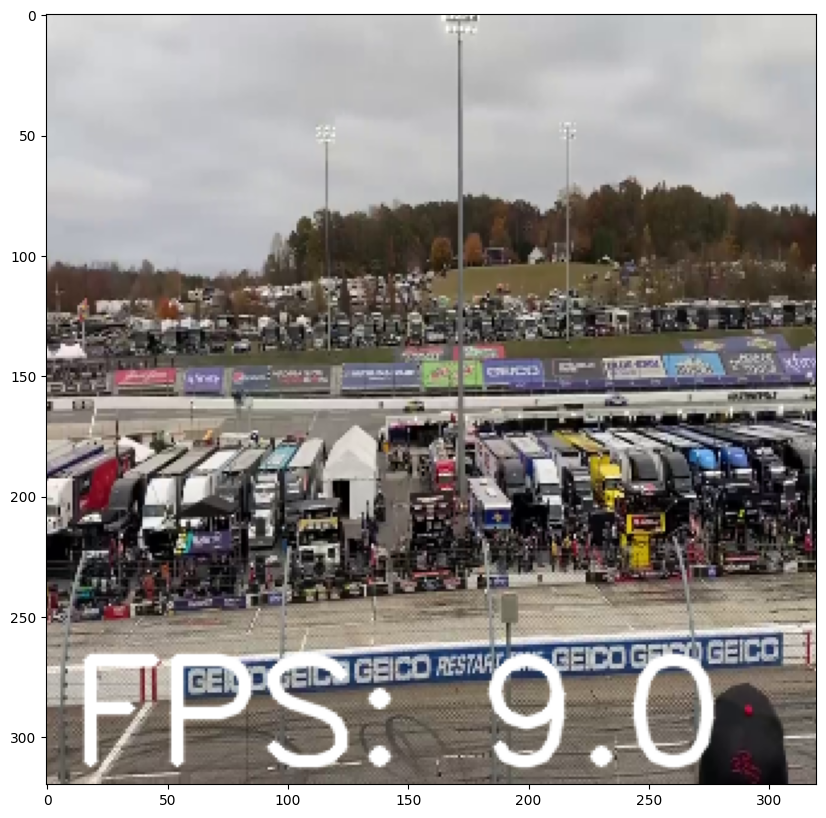

In [350]:
plt.imshow(frames[-1])

## Now let's put this in a video

In [248]:
# save to mp4
out = cv2.VideoWriter('chastain_wall_ride.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      video_fps,
                      (w, h))
 
for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
out.release()

### Now add back the audio

In [249]:
from moviepy.editor import CompositeAudioClip
detection_video = VideoFileClip('chastain_wall_ride.mp4')

# add sound and save
detection_video.audio = CompositeAudioClip([audioclip])
detection_video.write_videofile('chastain_wall_ride_with_audio.mp4')

Moviepy - Building video chastain_wall_ride_with_audio.mp4.
MoviePy - Writing audio in chastain_wall_ride_with_audioTEMP_MPY_wvf_snd.mp3


t:   0%|          | 0/1049 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video chastain_wall_ride_with_audio.mp4



t: 100%|██████████| 1049/1049 [01:50<00:00, 12.31it/s, now=None][2023-05-08 00:16:23] WARNING - warnings.py - /usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file chastain_wall_ride.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1048/1049, at time 34.97/35.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

